In [1]:
%matplotlib inline


# Task-related component analysis for SSVEP detection

Sample code for the task-related component analysis (TRCA)-based steady
-state visual evoked potential (SSVEP) detection method [1]_. The filter
bank analysis can also be combined to the TRCA-based algorithm [2]_ [3]_.

This code is based on the Matlab implementation from:
https://github.com/mnakanishi/TRCA-SSVEP

Uses `meegkit.trca.TRCA()`.

## References
.. [1] M. Nakanishi, Y. Wang, X. Chen, Y.-T. Wang, X. Gao, and T.-P. Jung,
   "Enhancing detection of SSVEPs for a high-speed brain speller using
   task-related component analysis", IEEE Trans. Biomed. Eng, 65(1): 104-112,
   2018.
.. [2] X. Chen, Y. Wang, S. Gao, T. -P. Jung and X. Gao, "Filter bank
   canonical correlation analysis for implementing a high-speed SSVEP-based
   brain-computer interface", J. Neural Eng., 12: 046008, 2015.
.. [3] X. Chen, Y. Wang, M. Nakanishi, X. Gao, T. -P. Jung, S. Gao,
   "High-speed spelling with a noninvasive brain-computer interface",
   Proc. Int. Natl. Acad. Sci. U. S. A, 112(44): E6058-6067, 2015.


In [2]:
# Authors: Giuseppe Ferraro <giuseppe.ferraro@isae-supaero.fr>
#          Nicolas Barascud <nicolas.barascud@gmail.com>
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from meegkit.trca import TRCA
from meegkit.utils.trca import itr, normfit, round_half_up

t = time.time()

## Parameters



In [3]:
dur_gaze = 0.5  # data length for target identification [s]
delay = 0.13  # visual latency being considered in the analysis [s]
n_bands = 5  # number of sub-bands in filter bank analysis
is_ensemble = True  # True = ensemble TRCA method; False = TRCA method
alpha_ci = 0.05   # 100*(1-alpha_ci): confidence interval for accuracy
sfreq = 250  # sampling rate [Hz]
dur_shift = 0.5  # duration for gaze shifting [s]
list_freqs = np.array(
    [[x + 8.0 for x in range(8)],
     [x + 8.2 for x in range(8)],
     [x + 8.4 for x in range(8)],
     [x + 8.6 for x in range(8)],
     [x + 8.8 for x in range(8)]]).T  # list of stimulus frequencies
n_targets = list_freqs.size  # The number of stimuli

# Useful variables (no need to modify)
dur_gaze_s = round_half_up(dur_gaze * sfreq)  # data length [samples]
delay_s = round_half_up(delay * sfreq)  # visual latency [samples]
dur_sel_s = dur_gaze + dur_shift  # selection time [s]
ci = 100 * (1 - alpha_ci)  # confidence interval

## Load data



In [4]:
path = os.path.join("..", "tests", "data", "trcadata.mat")
eeg = scipy.io.loadmat(path)["eeg"]

n_trials, n_chans, n_samples, n_blocks = eeg.shape

# Convert dummy Matlab format to (sample, channels, trials) and construct
# vector of labels
eeg = np.reshape(eeg.transpose([2, 1, 3, 0]),
                 (n_samples, n_chans, n_trials * n_blocks))
labels = np.array([x for x in range(n_targets)] * n_blocks)
crop_data = np.arange(delay_s, delay_s + dur_gaze_s)
eeg = eeg[crop_data]

## TRCA classification
Estimate classification performance with a Leave-One-Block-Out
cross-validation approach.

To get a sense of the filterbank specification in relation to the stimuli
we can plot the individual filterbank sub-bands as well as the target
frequencies (with their expected harmonics in the EEG spectrum). We use the
filterbank specification described in [2]_.



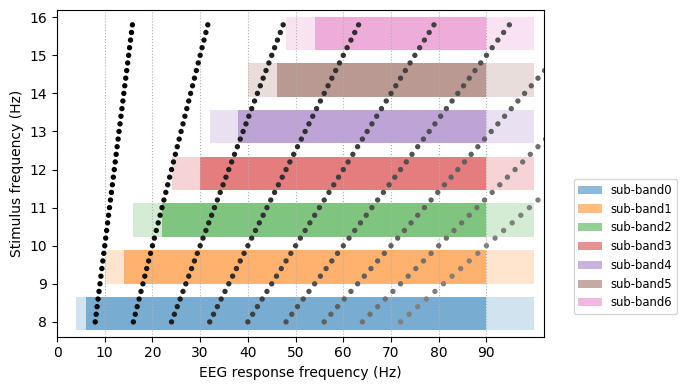

In [5]:
filterbank = [[(6, 90), (4, 100)],  # passband, stopband freqs [(Wp), (Ws)]
              [(14, 90), (10, 100)],
              [(22, 90), (16, 100)],
              [(30, 90), (24, 100)],
              [(38, 90), (32, 100)],
              [(46, 90), (40, 100)],
              [(54, 90), (48, 100)]]

f, ax = plt.subplots(1, figsize=(7, 4))
for i, _band in enumerate(filterbank):
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][1][0], xmax=filterbank[i][1][1],
               alpha=0.2, facecolor=f"C{i}")
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][0][0], xmax=filterbank[i][0][1],
               alpha=0.5, label=f"sub-band{i}", facecolor=f"C{i}")

for f in list_freqs.flat:
    colors = np.ones((9, 4))
    colors[:, :3] = np.linspace(0, .5, 9)[:, None]
    ax.scatter(f * np.arange(1, 10), [f] * 9, c=colors, s=8, zorder=100)

ax.set_ylabel("Stimulus frequency (Hz)")
ax.set_xlabel("EEG response frequency (Hz)")
ax.set_xlim([0, 102])
ax.set_xticks(np.arange(0, 100, 10))
ax.grid(True, ls=":", axis="x")
ax.legend(bbox_to_anchor=(1.05, .5), fontsize="small")
plt.tight_layout()
plt.show()

Now perform the TRCA-based SSVEP detection algorithm



In [6]:
trca = TRCA(sfreq, filterbank, is_ensemble)

print("Results of the ensemble TRCA-based method:\n")
accs = np.zeros(n_blocks)
itrs = np.zeros(n_blocks)
for i in range(n_blocks):

    # Select all folds except one for training
    traindata = np.concatenate(
        (eeg[..., :i * n_trials],
         eeg[..., (i + 1) * n_trials:]), 2)
    y_train = np.concatenate(
        (labels[:i * n_trials], labels[(i + 1) * n_trials:]), 0)

    # Construction of the spatial filter and the reference signals
    trca.fit(traindata, y_train)

    # Test stage
    testdata = eeg[..., i * n_trials:(i + 1) * n_trials]
    y_test = labels[i * n_trials:(i + 1) * n_trials]
    estimated = trca.predict(testdata)

    # Evaluation of the performance for this fold (accuracy and ITR)
    is_correct = estimated == y_test
    accs[i] = np.mean(is_correct) * 100
    itrs[i] = itr(n_targets, np.mean(is_correct), dur_sel_s)
    print(f"Block {i}: accuracy = {accs[i]:.1f}, \tITR = {itrs[i]:.1f}")

# Mean accuracy and ITR computation
mu, _, muci, _ = normfit(accs, alpha_ci)
print(f"\nMean accuracy = {mu:.1f}%\t({ci:.0f}% CI: {muci[0]:.1f}-{muci[1]:.1f}%)")  # noqa

mu, _, muci, _ = normfit(itrs, alpha_ci)
print(f"Mean ITR = {mu:.1f}\t({ci:.0f}% CI: {muci[0]:.1f}-{muci[1]:.1f})")
if is_ensemble:
    ensemble = "ensemble TRCA-based method"
else:
    ensemble = "TRCA-based method"

print(f"\nElapsed time: {time.time()-t:.1f} seconds")

Results of the ensemble TRCA-based method:

Block 0: accuracy = 97.5, 	ITR = 301.3
Block 1: accuracy = 100.0, 	ITR = 319.3
Block 2: accuracy = 95.0, 	ITR = 286.3
Block 3: accuracy = 95.0, 	ITR = 286.3
Block 4: accuracy = 95.0, 	ITR = 286.3
Block 5: accuracy = 100.0, 	ITR = 319.3

Mean accuracy = 97.1%	(95% CI: 97.0-97.1%)
Mean ITR = 299.8	(95% CI: 299.4-300.2)

Elapsed time: 9.5 seconds
